In [65]:
from halotools.sim_manager import CachedHaloCatalog
from halotools.empirical_models import PrebuiltHodModelFactory, Zheng07Cens, Zheng07Sats, TrivialPhaseSpace, NFWPhaseSpace, HodModelFactory
import numpy as np
from astropy.utils.misc import NumpyRNGContext
from scipy.interpolate import interp1d
from scipy.special import erf,pdtrik
from halotools.utils.array_utils import custom_len
import warnings
from Corrfunc.theory.wp import wp
from halotools.mock_observables import return_xyz_formatted_array
import gc
from numpy.linalg import inv
import matplotlib.pyplot as plt

In [59]:
dname = '20'

In [62]:
if '21' in dname:
    print(threshold)
    import zehavi_data_file_21
    wp_ng_vals = zehavi_data_file_21.get_wp()[0:12]
    bin_edges = zehavi_data_file_21.get_bins()[0:12]
    cov_matrix = zehavi_data_file_21.get_cov()[0:11,0:11]
    err = np.array([cov_matrix[i,i] for i in range(len(cov_matrix))])
    bin_cen = (bin_edges[1:]+bin_edges[:-1])/2.
    ng = wp_ng_vals[0]
    ng_err = 0.000005
    invcov = inv(cov_matrix)
    wp_vals = wp_ng_vals[1:12]
if '19' in dname:
    print('19')
    import zehavi_data_file_19
    wp_ng_vals = zehavi_data_file_19.get_wp()[0:12]
    bin_edges = zehavi_data_file_19.get_bins()[0:12]
    cov_matrix = zehavi_data_file_19.get_cov()[0:11,0:11]
    err = np.array([cov_matrix[i,i] for i in range(len(cov_matrix))])    
    bin_cen = (bin_edges[1:]+bin_edges[:-1])/2.
if '20' in dname:
    import zehavi_data_file_20
    wp_ng_vals = zehavi_data_file_20.get_wp()[0:12]
    bin_edges = zehavi_data_file_20.get_bins()[0:12]
    cov_matrix = zehavi_data_file_20.get_cov()[0:11,0:11]
    invcov = inv(cov_matrix)
    err = np.array([cov_matrix[i,i] for i in range(len(cov_matrix))])    
    bin_cen = (bin_edges[1:]+bin_edges[:-1])/2.
    ng = wp_ng_vals[0]
    ng_err = 0.00007
    wp_vals = wp_ng_vals[1:12]

In [38]:
def bind_required_kwargs(required_kwargs, obj, **kwargs):
    r""" Method binds each element of ``required_kwargs`` to
    the input object ``obj``, or raises and exception for cases
    where a mandatory keyword argument was not passed to the
    ``obj`` constructor.

    Used throughout the package when a required keyword argument
    has no obvious default value.

    Parameters
    ----------
    required_kwargs : list
        List of strings of the keyword arguments that are required
        when instantiating the input ``obj``.

    obj : object
        The object being instantiated.

    Notes
    -----
    The `bind_required_kwargs` method assumes that each
    required keyword argument should be bound to ``obj``
    as attribute with the same name as the keyword.
    """
    for key in required_kwargs:
        if key in list(kwargs.keys()):
            setattr(obj, key, kwargs[key])
        else:
            class_name = obj.__class__.__name__
            msg = (
                key + ' is a required keyword argument ' +
                'to instantiate the '+class_name+' class'
                )
            raise KeyError(msg)


In [39]:
class OccupationComponent(object):

    def __init__(self, **kwargs):
        """
        Parameters
        ----------
        gal_type : string, keyword argument
            Name of the galaxy population whose occupation statistics is being modeled.

        threshold : float, keyword argument
            Threshold value defining the selection function of the galaxy population
            being modeled. Typically refers to absolute magnitude or stellar mass.

        upper_occupation_bound : float, keyword argument
            Upper bound on the number of gal_type galaxies per halo.
            The only currently supported values are unity or infinity.

        second_moment : string, optional
            Method for computing the second occupation moment.
            For centrals, only Bernoulli is supported.
            For satellites, options are "poisson" and "weighted_nearest_integer".
            Satellite default is "poisson".

        prim_haloprop_key : string, optional
            String giving the column name of the primary halo property governing
            the occupation statistics of gal_type galaxies, e.g., ``halo_mvir``.

        See also
        ---------
        :ref:`writing_your_own_hod_occupation_component`
        """
        required_kwargs = ["gal_type", "threshold"]
        bind_required_kwargs(required_kwargs, self, **kwargs)

        try:
            self.prim_haloprop_key = kwargs["prim_haloprop_key"]
            self.sec_haloprop_key = kwargs["sec_haloprop_key"]
        except:
            pass

        try:
            self._upper_occupation_bound = kwargs["upper_occupation_bound"]
        except KeyError:
            msg = "\n``upper_occupation_bound`` is a required keyword argument of OccupationComponent\n"
            raise KeyError(msg)

        self._lower_occupation_bound = 0.0

        self._second_moment = kwargs.get("second_moment", "poisson")

        if not hasattr(self, "param_dict"):
            self.param_dict = {}

        # Enforce the requirement that sub-classes have been configured properly
        required_method_name = "mean_occupation"
        if not hasattr(self, required_method_name):
            raise SyntaxError(
                "Any sub-class of OccupationComponent must "
                "implement a method named %s " % required_method_name
            )

        try:
            self.redshift = kwargs["redshift"]
        except KeyError:
            pass

        # The _methods_to_inherit determines which methods will be directly callable
        # by the composite model built by the HodModelFactory
        try:
            self._methods_to_inherit.extend(["mc_occupation", "mean_occupation"])
        except AttributeError:
            self._methods_to_inherit = ["mc_occupation", "mean_occupation"]

        # The _attrs_to_inherit determines which methods will be directly bound
        # to the composite model built by the HodModelFactory
        try:
            self._attrs_to_inherit.append("threshold")
        except AttributeError:
            self._attrs_to_inherit = ["threshold"]

        if not hasattr(self, "publications"):
            self.publications = []

        # The _mock_generation_calling_sequence determines which methods
        # will be called during mock population, as well as in what order they will be called
        self._mock_generation_calling_sequence = ["mc_occupation"]
        self._galprop_dtypes_to_allocate = np.dtype(
            [("halo_num_" + self.gal_type, "i4")]
        )

    def mc_occupation(self, seed=None, **kwargs):
        """ Method to generate Monte Carlo realizations of the abundance of galaxies.

        Parameters
        ----------
        prim_haloprop : array, optional
            Array of mass-like variable upon which occupation statistics are based.
            If ``prim_haloprop`` is not passed, then ``table`` keyword argument must be passed.

        table : object, optional
            Data table storing halo catalog.
            If ``table`` is not passed, then ``prim_haloprop`` keyword argument must be passed.

        seed : int, optional
            Random number seed used to generate the Monte Carlo realization.
            Default is None.

        Returns
        -------
        mc_abundance : array
            Integer array giving the number of galaxies in each of the input table.
        """
        first_occupation_moment = self.mean_occupation(**kwargs)
        if self._upper_occupation_bound == 1:
            return self._nearest_integer_distribution(
                first_occupation_moment, seed=seed, **kwargs
            )
        elif self._upper_occupation_bound == float("inf"):
            if self._second_moment == "poisson":
                return self._poisson_distribution(
                    first_occupation_moment, seed=seed, **kwargs
                )
            elif self._second_moment == "weighted_nearest_integer":
                return self._weighted_nearest_integer(
                    first_occupation_moment, seed=seed, **kwargs
                )
            else:
                raise ValueError("Unrecognized second moment")
        else:
            msg = (
                "\nYou have chosen to set ``_upper_occupation_bound`` to some value \n"
                "besides 1 or infinity. In such cases, you must also \n"
                "write your own ``mc_occupation`` method that overrides the method in the \n"
                "OccupationComponent super-class\n"
            )
            raise HalotoolsError(msg)


    def _nearest_integer_distribution(
        self, first_occupation_moment, seed=None, **kwargs
    ):
        """ Nearest-integer distribution used to draw Monte Carlo occupation statistics
        for central-like populations with only permissible galaxy per halo.

        Parameters
        ----------
        first_occupation_moment : array
            Array giving the first moment of the occupation distribution function.

        seed : int, optional
            Random number seed used to generate the Monte Carlo realization.
            Default is None.

        Returns
        -------
        mc_abundance : array
            Integer array giving the number of galaxies in each of the input table.
        """
        with NumpyRNGContext(seed):
            mc_generator = np.random.random(custom_len(first_occupation_moment))

        result = np.where(mc_generator < first_occupation_moment, 1, 0)
        if "table" in kwargs:
            kwargs["table"]["halo_num_" + self.gal_type] = result
        return result

    def _poisson_distribution(self, first_occupation_moment, seed=None, **kwargs):
        """ Poisson distribution used to draw Monte Carlo occupation statistics
        for satellite-like populations in which per-halo abundances are unbounded.

        Parameters
        ----------
        first_occupation_moment : array
            Array giving the first moment of the occupation distribution function.

        seed : int, optional
            Random number seed used to generate the Monte Carlo realization.
            Default is None.

        Returns
        -------
        mc_abundance : array
            Integer array giving the number of galaxies in each of the input table.
        """
        # We don't use the built-in Poisson number generator so that when a seed
        # is specified, it preserves the ranks among rvs even when mean is changed.
        with NumpyRNGContext(seed):
            result = np.ceil(
                pdtrik(
                    np.random.rand(*first_occupation_moment.shape),
                    first_occupation_moment,
                )
            ).astype(np.int)
        if "table" in kwargs:
            kwargs["table"]["halo_num_" + self.gal_type] = result
        return result

    def _weighted_nearest_integer(self, first_occupation_moment, seed=None, **kwargs):
        """ Non-Poisson distribution for satellite occupation statistics.
        If <Nsat> = i + r where r is the remainder, then the Monte Carlo realization
        will produce Nsat = i with probability r, and Nsat = i + 1 with probability 1-r.

        Parameters
        ----------
        first_occupation_moment : array
            Array giving the first moment of the occupation distribution function.

        seed : int, optional
            Random number seed used to generate the Monte Carlo realization.
            Default is None.

        Returns
        -------
        mc_abundance : array
            Integer array giving the number of galaxies in each of the input table.
        """
        nsat_lo = np.floor(first_occupation_moment)
        with NumpyRNGContext(seed):
            uran = np.random.uniform(nsat_lo, nsat_lo + 1, first_occupation_moment.size)
        result = np.where(uran > first_occupation_moment, nsat_lo, nsat_lo + 1)
        if "table" in kwargs:
            kwargs["table"]["halo_num_" + self.gal_type] = result
        return result

In [3]:
halocat = CachedHaloCatalog(fname = '/Users/lmezini/.astropy/cache/halotools/halo_catalogs/SMDPL/rockstar/smdpl.dat.smdpl2.hdf5',update_cached_fname = True)

/anaconda3/envs/haloenv/lib/python3.7/site-packages/halotools/sim_manager/halo_table_cache.py:321: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(fname)
/anaconda3/envs/haloenv/lib/python3.7/site-packages/halotools/sim_manager/halo_table_cache.py:338: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(fname)
/anaconda3/envs/haloenv/lib/python3.7/site-packages/ha

In [31]:
halocat.redshift=0.
G =  4.302*(10**-9.)
mvir = halocat.halo_table['halo_mvir']
rvir = halocat.halo_table['halo_rvir']
hms = halocat.halo_table['halo_halfmass_scale']
vmax = halocat.halo_table['halo_vmax']
vvir = np.sqrt((G*mvir)/rvir)

cnfw = np.linspace(1, 1400,140000)
vmax_interp = np.sqrt(0.2162166 * 1.0/( (np.log(1+cnfw)/cnfw) - (1/(1+cnfw)) ) )
get_c = interp1d(vmax_interp,cnfw,fill_value='extrapolate')
c = get_c(vmax/vvir)

num_bins = abs(int((np.min(np.log10(mvir))-np.max(np.log10(mvir)))*10))
bins=np.logspace(np.min(np.log10(mvir)),np.max(np.log10(mvir)),num=num_bins)

delta = []
mass = []
con = []
for i in range(1,num_bins):
    mask = np.logical_and(mvir>bins[i-1],mvir<bins[i])
    delta.append((c[mask]-np.mean(c[mask]))/np.std(c[mask]))
    mass.append(mvir[mask])
    con.append(c[mask])
mass = np.concatenate(mass)
delta = np.concatenate(delta)[np.argsort(mass)[::-1]]
con = np.concatenate(con)[np.argsort(mass)[::-1]]
mass = mass[np.argsort(mass)[::-1]]

halocat.halo_table['delta'] = delta

In [71]:
class mod_zheng07Cens(OccupationComponent):
    
    def __init__(self,
            threshold=20,
            prim_haloprop_key="halo_mvir",
            sec_haloprop_key = "halo_vmax"
            ):
        
        upper_occupation_bound = 1.0

        # Call the super class constructor, which binds all the
        # arguments to the instance.
        super(mod_zheng07Cens, self).__init__(
            gal_type='centrals',threshold=threshold, upper_occupation_bound=upper_occupation_bound,
            prim_haloprop_key=prim_haloprop_key, sec_haloprop_key = sec_haloprop_key,
            )
        mass_params = self.get_published_parameters(self.threshold)
        self.param_dict = (
                {'logMmin': mass_params['logMmin'],
                'sigma_logM': mass_params['sigma_logM'],
                'a': 0.0}
                )
        self.publications = ['arXiv:0408564', 'arXiv:0703457']
        print(self.param_dict)
    def mean_occupation(self,**kwargs):
        
        # Retrieve the array storing the mass-like variable
        if 'table' in list(kwargs.keys()):
            prop1 = kwargs['table'][self.prim_haloprop_key]
            prop2 = kwargs['table'][self.sec_haloprop_key]
        elif 'prim_haloprop' in list(kwargs.keys()):
            prop1 = np.atleast_1d(kwargs['prim_haloprop'])
            prop2 = np.atleast_1d(kwargs['sec_haloprop'])
        else:
            msg = ("\nYou must pass either a ``table`` or ``prim_haloprop`` argument \n"
                "to the ``mean_occupation`` function of the ``Zheng07Cens`` class.\n")
            print(msg)

        logM = np.log10(prop1) + self.param_dict['a']*prop2
        mean_ncen = 0.5*(1.0 + erf(
            (logM - self.param_dict['logMmin']) / self.param_dict['sigma_logM']))

        return mean_ncen

    def get_published_parameters(self, threshold, publication='Zheng07'):
        
        def get_zheng07_params(threshold):
            # Load tabulated data from Zheng et al. 2007, Table 1
            logMmin_array = [11.35, 11.46, 11.6, 11.75, 12.02, 12.3, 12.79, 13.38, 14.22]
            sigma_logM_array = [0.25, 0.24, 0.26, 0.28, 0.26, 0.21, 0.39, 0.51, 0.77]
            # define the luminosity thresholds corresponding to the above data
            threshold_array = np.arange(-22, -17.5, 0.5)
            threshold_array = threshold_array[::-1]

            threshold_index = np.where(threshold_array == threshold)[0]
            if len(threshold_index) == 0:
                msg = ("\nInput luminosity threshold "
                    "does not match any of the Table 1 values \nof "
                    "Zheng et al. 2007 (arXiv:0703457).\n"
                    "Choosing the best-fit parameters "
                    "associated the default_luminosity_threshold variable \n"
                    "set in the model_defaults module.\n"
                    "You can always manually change the values in ``param_dict``.\n")
                warnings.warn(msg)
                threshold = 20
                threshold_index = np.where(threshold_array == threshold)[0]

            mass_param_dict = (
                {'logMmin': logMmin_array[threshold_index[0]],
                'sigma_logM': sigma_logM_array[threshold_index[0]]}
                )

            return mass_param_dict

        if publication in ['zheng07', 'Zheng07', 'Zheng_etal07', 'zheng_etal07', 'zheng2007', 'Zheng2007']:
            param_dict = get_zheng07_params(threshold)
            return param_dict
        else:
            raise KeyError("For Zheng07Cens, only supported best-fit models are currently Zheng et al. 2007")

In [46]:
class mod_zheng07Sats(OccupationComponent):
    

    def __init__(self,
            threshold=20,
            prim_haloprop_key="halo_mvir", sec_haloprop_key = "halo_vmax",
            modulate_with_cenocc=True, cenocc_model=None):
        
        upper_occupation_bound = float("inf")

        # Call the super class constructor, which binds all the
        # arguments to the instance.
        super(mod_zheng07Sats, self).__init__(gal_type='satellites', threshold=threshold,
            upper_occupation_bound=upper_occupation_bound,
            prim_haloprop_key=prim_haloprop_key,
            sec_haloprop_key=sec_haloprop_key,
        )

        mass_params = self.get_published_parameters(self.threshold)
        self.param_dict = (
                {'logM0': mass_params['logM0'],
                'logM1': mass_params['logM1'],
                'alpha': mass_params['alpha']}
                )
        self.publications = ['arXiv:0308519', 'arXiv:0703457']

        if cenocc_model is None:
            cenocc_model = mod_zheng07Cens(
                prim_haloprop_key=prim_haloprop_key, 
                sec_haloprop_key=sec_haloprop_key,
                threshold=threshold)
        else:
            if modulate_with_cenocc is False:
                msg = ("You chose to input a ``cenocc_model``, but you set the \n"
                    "``modulate_with_cenocc`` keyword to False, so your "
                    "``cenocc_model`` will have no impact on the model's behavior.\n"
                    "Be sure this is what you intend before proceeding.\n"
                    "Refer to the Zheng et al. (2007) composite model tutorial for details.\n")
                warnings.warn(msg)

        self.modulate_with_cenocc = modulate_with_cenocc
        if self.modulate_with_cenocc:
            try:
                assert isinstance(cenocc_model, OccupationComponent)
            except AssertionError:
                msg = ("The input ``cenocc_model`` must be an instance of \n"
                    "``OccupationComponent`` or one of its sub-classes.\n")
                print(msg)

            self.central_occupation_model = cenocc_model

            self.param_dict.update(self.central_occupation_model.param_dict)


    def mean_occupation(self,**kwargs):

        if self.modulate_with_cenocc:
            for key, value in list(self.param_dict.items()):
                if key in self.central_occupation_model.param_dict:
                    self.central_occupation_model.param_dict[key] = value

        # Retrieve the array storing the mass-like variable
        if 'table' in list(kwargs.keys()):
            prop1 = kwargs['table'][self.prim_haloprop_key]
            prop2 = kwargs['table'][self.sec_haloprop_key]
        elif 'prim_haloprop' in list(kwargs.keys()):
            prop1 = np.atleast_1d(kwargs['prim_haloprop'])
            prop2 = np.atleast_1d(kwargs['sec_haloprop'])
        else:
            msg = ("\nYou must pass either a ``table`` or ``prim_haloprop`` argument \n"
                "to the ``mean_occupation`` function of the ``Zheng07Sats`` class.\n")
            print(msg)

        M0 = 10.**self.param_dict['logM0']
        M1 = 10.**self.param_dict['logM1']
        a = self.param_dict['a']
        # Call to np.where raises a harmless RuntimeWarning exception if
        # there are entries of input logM for which mean_nsat = 0
        # Evaluating mean_nsat using the catch_warnings context manager
        # suppresses this warning
        mass = 10.**(np.log10(prop1)+a*prop2)
        mean_nsat = np.zeros_like(mass)

        idx_nonzero = np.where(mass - M0 > 0)[0]
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", RuntimeWarning)

            mean_nsat[idx_nonzero] = ((mass[idx_nonzero] - M0)/M1)**self.param_dict['alpha']

        # If a central occupation model was passed to the constructor,
        # multiply mean_nsat by an overall factor of mean_ncen
        if self.modulate_with_cenocc:
            # compatible with AB models
            mean_ncen = getattr(self.central_occupation_model, "baseline_mean_occupation",\
                                    self.central_occupation_model.mean_occupation)(**kwargs)
            mean_nsat *= mean_ncen

        return mean_nsat

    def get_published_parameters(self, threshold, publication='Zheng07'):

        def get_zheng07_params(threshold):
            # Load tabulated data from Zheng et al. 2007, Table 1
            logM0_array = [11.2, 10.59, 11.49, 11.69, 11.38, 11.84, 11.92, 13.94, 14.0]
            logM1_array = [12.4, 12.68, 12.83, 13.01, 13.31, 13.58, 13.94, 13.91, 14.69]
            alpha_array = [0.83, 0.97, 1.02, 1.06, 1.06, 1.12, 1.15, 1.04, 0.87]
            # define the luminosity thresholds corresponding to the above data
            threshold_array = np.arange(-22, -17.5, 0.5)
            threshold_array = threshold_array[::-1]

            threshold_index = np.where(threshold_array == threshold)[0]

            if len(threshold_index) == 0:
                msg = ("\nInput luminosity threshold "
                    "does not match any of the Table 1 values \nof "
                    "Zheng et al. 2007 (arXiv:0703457).\n"
                    "Choosing the best-fit parameters "
                    "associated the default_luminosity_threshold variable \n"
                    "set in the model_defaults module.\n"
                    "You can always manually change the values in ``param_dict``.\n")
                warnings.warn(msg)
                threshold = model_defaults.default_luminosity_threshold
                threshold_index = np.where(threshold_array == threshold)[0]
                warnings.warn(msg)

            mass_param_dict = (
                {'logM0': logM0_array[threshold_index[0]],
                'logM1': logM1_array[threshold_index[0]],
                'alpha': alpha_array[threshold_index[0]]}
                )
            return mass_param_dict

        if publication in ['zheng07', 'Zheng07', 'Zheng_etal07', 'zheng_etal07', 'zheng2007', 'Zheng2007']:
            param_dict = get_zheng07_params(threshold)
            return param_dict
        else:
            raise KeyError("For Zheng07Sats, only supported best-fit models are currently Zheng et al. 2007")



In [72]:
cens_occ_model = mod_zheng07Cens(prim_haloprop_key = 'halo_mvir', 
                            sec_haloprop_key = 'delta',threshold=-21)
cens_prof_model = TrivialPhaseSpace()

sats_occ_model =  mod_zheng07Sats(prim_haloprop_key = 'halo_mvir', 
                                sec_haloprop_key = 'delta',modulate_with_cenocc=True,
                                  threshold=-21)
sats_prof_model = NFWPhaseSpace()

model_instance = HodModelFactory(centrals_occupation = cens_occ_model,
                                     centrals_profile = cens_prof_model,
                                     satellites_occupation = sats_occ_model,
                                     satellites_profile = sats_prof_model)
model_instance.populate_mock(halocat)

{'logMmin': 12.79, 'sigma_logM': 0.39, 'a': 0.0}
{'logMmin': 12.79, 'sigma_logM': 0.39, 'a': 0.0}


/anaconda3/envs/haloenv/lib/python3.7/site-packages/halotools/empirical_models/factories/hod_model_factory.py:741: UserWarning: 

The param_dict key logMmin appears in more than one component model.
This is permissible, but if you are seeing this message you should be sure you understand it.
In particular, double-check that this parameter does not have conflicting meanings across components.

If you do not wish to see this message every time you instantiate, 
simply attach a _suppress_repeated_param_warning attribute 
to any of your component models and set this variable to ``True``.

  warn(msg % key)
/anaconda3/envs/haloenv/lib/python3.7/site-packages/halotools/empirical_models/factories/hod_model_factory.py:741: UserWarning: 

The param_dict key a appears in more than one component model.
This is permissible, but if you are seeing this message you should be sure you understand it.
In particular, double-check that this parameter does not have conflicting meanings across components.



In [55]:
model_instance.mock.estimate_ngals()

69157

In [75]:
a,logMmin,sigma_logM,alpha,logM0,logM1 = [-0.06280481, 11.93011227,  0.2558386, 1.03464175, 12.17365275, 13.21302311]
model_instance.param_dict['a'] = a
model_instance.param_dict['logMmin'] = logMmin
model_instance.param_dict['sigma_logM'] = sigma_logM
model_instance.param_dict['alpha'] = alpha
model_instance.param_dict['logM0'] = logM0
model_instance.param_dict['logM1'] = logM1

#est_ngals = model_instance.mock.estimate_ngals()
#if est_ngals/(400**3) > 2*ng:
#    print("True")
#    return -np.inf

model_instance.mock.populate()
gc.collect()
Lbox = 400.
pos = return_xyz_formatted_array(model_instance.mock.galaxy_table['x'],
                                            model_instance.mock.galaxy_table['y'],
                                            model_instance.mock.galaxy_table['z'],
                                            period = Lbox)
x = pos[:,0]
y = pos[:,1]
z = pos[:,2]
velz = model_instance.mock.galaxy_table['vz']
pos_zdist = return_xyz_formatted_array(x,y,z,period=Lbox,velocity=velz,
                                    velocity_distortion_dimension='z')

pi_max = 60.
nthreads = 1

wp_calc = wp(Lbox,pi_max,nthreads,bin_edges,pos_zdist[:,0],
                        pos_zdist[:,1],pos_zdist[:,2],verbose=False)

/anaconda3/envs/haloenv/lib/python3.7/site-packages/halotools/empirical_models/phase_space_models/analytic_models/monte_carlo_helpers.py:205: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.rad_prof_func_table_indices[digitized_param_list]
/anaconda3/envs/haloenv/lib/python3.7/site-packages/halotools/empirical_models/phase_space_models/analytic_models/monte_carlo_helpers.py:522: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.rad_prof_func_table_indices[digitized_param_list]


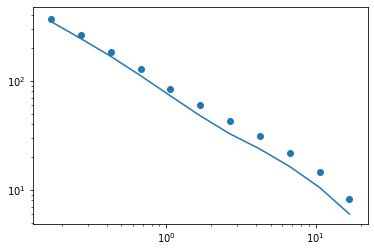

In [68]:
plt.loglog(bin_cen,wp_calc['wp'])
plt.scatter(bin_cen,wp_vals)
